In [1]:
import cv2
import numpy as np
import math
import os
import time 
from six.moves import cPickle as pickle
from matplotlib import pyplot as plt
from scipy import signal


# Resize images to 10*10

In [44]:
def resizeImages(sor,dest,shape):
    for ls in os.listdir(sor):
        img = cv2.cvtColor(cv2.imread(os.path.join(sor,ls)), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(dest,ls),cv2.resize(img,shape))

#resizeImages("./TrueData","./ResizedData/true",(10,10))
#resizeImages("./FalseData","./ResizedData/false",(10,10))

# Augment data to increase dataset 
## 228 images in true dataset - > 851 images
## 351 images in false dataset - > 601 images

In [83]:
import Augmentor
p_false = Augmentor.Pipeline("./ResizedData/false")
p_true = Augmentor.Pipeline("./ResizedData/true")

Initialised with 224 image(s) found.
Output directory set to ./ResizedData/true2\output.

In [84]:
#false values 
p_false.rotate90(probability=0.5)
p_false.rotate270(probability=0.5)
p_false.flip_left_right(probability=0.8)
p_false.flip_top_bottom(probability=0.3)

#true values
p_true.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p_true.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

In [85]:
p_false.sample(250)
p_true.sample(300)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=L size=10x10 at 0x25DA85D6518>: 100%|█| 300/300 [00:03<00:00, 75.85 Samples/s] 


In [86]:
root = './ResizedData'
datafolders = [os.path.join(root,d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root,d))]

# Create Pickle files to store complete dataset as numpy array 

In [87]:
image_size = 10
pixel_depth = 255.0

def load_letter(folder):
    # Load data for single label
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size,image_size),dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder,image)
        try:
            
            image_data = ((cv2.cvtColor(cv2.imread(image_file),cv2.COLOR_BGR2GRAY).astype(float) - pixel_depth / 2) / pixel_depth)
            if image_data.shape != (image_size,image_size):
                 raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images += 1
        except (IOError,ValueError) as e:
            print('Could not read:',image_file,":",e,'- it\'s ok, skipping.')
    dataset = dataset[0:num_images,:,:]
    print('Full dataset tensor:',dataset.shape)
    print('Mean:',np.mean(dataset))
    print('Standard deviation:',np.std(dataset))
    return dataset

def maybe_pickle(data_folders, force =False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder+'.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exaception as e:
                print('Unable to save data to', set_filename,":",e)
    return dataset_names


datasets = maybe_pickle(datafolders)

./ResizedData\false.pickle already present - Skipping pickling.
Pickling ./ResizedData\true.pickle.
Full dataset tensor: (898, 10, 10)
Mean: -0.22358853
Standard deviation: 0.36739373


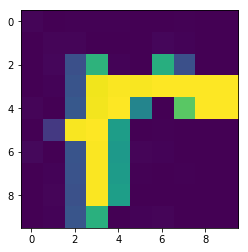

In [88]:
pickle_file = datasets[1]
with open(pickle_file,'rb') as f:
    letter_set = pickle.load(f) #unppickle
    sample_idx = 43
    sample_image = letter_set[sample_idx,:,:]
    plt.figure()
    plt.imshow(sample_image)

# Create pickle files for 20 % test and 80 % training data
 ## 0 - label for Not GCP ; 1 - for GCP   

In [ ]:
# def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size,img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None,None
    return dataset, labels


def merge_datasets(pickle_files, test_percent):
    num_classes = len(pickle_files)
    
    path = os.path.join('.','ResizedData')
    
    t = os.listdir(path)

    test_size, train_size = 0,0

    for i in t:
        address = os.path.join(path,i)
        if os.path.isdir(address):
            leng = len(os.listdir(address))
            t = math.floor(leng * (test_percent/100))
            test_size += t
            train_size += leng - t
            
    
   
    train_dataset, train_labels = make_arrays(train_size, image_size)
    test_dataset, test_labels = make_arrays(test_size, image_size)
    
    start_train,start_test = 0,0
    end_train,end_test = 0,0
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                np.random.shuffle(letter_set)
                length = len(letter_set)
                
                test_size = math.floor((test_percent/100)*length)
                train_size = length-test_size
                
                end_test = start_test + test_size
                test_dataset[start_test:end_test,:,:] = letter_set[:test_size,:,:]
                test_labels[start_test:end_test] = label
                start_test = end_test
                
                end_train = start_train + train_size
                train_dataset[start_train:end_train,:,:] = letter_set[test_size:,:,:]
                train_labels[start_train:end_train] = label
                start_train = end_train
               
        except Exception as e:
            print('Unable to process data from', pickle_file, ':',e)
            raise
    
    return test_dataset,test_labels,train_dataset,train_labels

test_percent = 20

test_dataset,test_labels,train_dataset,train_labels = merge_datasets(datasets, test_percent)


# Shuffle the data

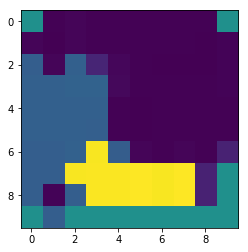

1


In [94]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)


plt.imshow(signal.medfilt(train_dataset[0]), interpolation='nearest')
plt.show() 
print(train_labels[0])
    

# Save pickle file for complete dataset as a dictionary for both test and training data

In [95]:
pickle_file = os.path.join('./ResizedData','complete_dataset.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset' : train_dataset,
        'train_labels' : train_labels,
        'test_dataset' : test_dataset,
        'test_labels' : test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e :
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [96]:
statinfo = os.stat(pickle_file)
print('Compresed pickle size: ', statinfo.st_size)

Compresed pickle size:  605977
